## Data ##

This analysis implements random forest classifier to predict direction of crypto currencies. The model is trained for nine crypto currencies, using technical and momentum features, to forecast the direction on the next day. The model is trained on the last one year of daily data and the model is used for next one month to forecast direction on a daily basis. The model accuracy varies from 55% to 60%. However, the backtest result shows modest profitability along with high daily volatility. The model accuracy can be further enhanced by incorporating additional crypto currencies specific features and sentiment indicators. However due to lack of additional data, we focused solely on technical features.   

## Data Universe ##

The data set contains minutely Open, High, Low, Close and Volume data for 429 crypto currency pairs.  The data series starts from 01-Apr-2013 for **btcusd** which by far the most traded pair and has the highest liquidity and largest amount of data available.

We used following filterings to select liquid crypto currency pairs which have sufficient history available for the analysis.

1. We selected top 100 cryptocurrency pairs based on the number of rows in the data file.
2. We excluded all the cryptocurrency pairs having start date after 1 Jan 2018.
3. We removed all the cryptocurrency pairs having average daily turnover below 5m $.

This filtering gives us following list of cryptocurrency pairs for further analysis.
1. xrpusd
2. ethusd
3. btcusd
4. eosusd
5. btceur
6. ethbtc
7. iotusd
8. neousd
9. ltcusd

In [21]:
\l ml/ml.q
.ml.loadfile`:init.q;
\l utils/util.q
\l utils/graphics.q

In [22]:
//Count number of rows in each files from data folder for selecting top 50 cryptocurrency
dataDirPath: hsym[`$"data/"];
files: key dataDirPath;
rowCountTbl: {[path;file] 
    n:count read0 ` sv path,file; 
    :([] file:enlist file;rowcount:n)}[dataDirPath;] each files;
rowCountTbl:`rowcount xdesc raze rowCountTbl;

In [23]:
show 5#rowCountTbl;

file       rowcount
-------------------
btcusd.csv 3691472 
ethusd.csv 2474411 
ltcusd.csv 2315790 
xrpusd.csv 2133169 
ethbtc.csv 1843441 


In [24]:
//Filter 1: select top 100 instruments by row count for further analysis
files:100#rowCountTbl[`file];

In [6]:
//load data for top 100 instruments in priceDataTbl
loadFile: {[path;file]
    -1"processing file: ", string[file];
    symbol : first[` vs file];
    :update sym:symbol, time:1970.01.01+0D00:00:00.001*time from ("JFFFFF";enlist csv) 0: ` sv path,file;
    };
priceDataTbl: `sym`time xcols raze loadFile[dataDirPath;] each files;

processing file: btcusd.csv
processing file: ethusd.csv
processing file: ltcusd.csv
processing file: xrpusd.csv
processing file: ethbtc.csv
processing file: eosusd.csv
processing file: btceur.csv
processing file: iotusd.csv
processing file: ltcbtc.csv
processing file: etcusd.csv
processing file: neousd.csv
processing file: omgusd.csv
processing file: zecusd.csv
processing file: xrpbtc.csv
processing file: dshusd.csv
processing file: leousd.csv
processing file: ustusd.csv
processing file: xmrusd.csv
processing file: eosbtc.csv
processing file: etheur.csv
processing file: iotbtc.csv
processing file: btcjpy.csv
processing file: btcust.csv
processing file: btcgbp.csv
processing file: omgbtc.csv
processing file: etcbtc.csv
processing file: trxusd.csv
processing file: ethust.csv
processing file: xmrbtc.csv
processing file: zecbtc.csv
processing file: dshbtc.csv
processing file: ethjpy.csv
processing file: bsvusd.csv
processing file: etpusd.csv
processing file: neobtc.csv
processing file: xtz

In [25]:
// convert minutely price data into daily data
dailyTbl:select first open, max high, min low, last close, sum volume by sym, date:`date$time from priceDataTbl;

In [26]:
// Filter out syms with start date after 2018.01.01
symsSdFilter: exec distinct sym from dailyTbl where 2018.01.01>(min;date) fby sym;
// Filter out syms with avg turnover below 5m assuming 1USD ~ 1 EUR
symsTurnoverFilter: exec distinct sym from dailyTbl where 5000000 < (avg;close*volume) fby sym;
// select syms based on start date and turnover filter
syms: symsSdFilter inter symsTurnoverFilter;
show syms;

`btceur`btcusd`eosusd`etcusd`ethusd`iotusd`ltcusd`neousd`xrpusd


In [27]:
//Only store the data of the selected cryptocurrencies
dailyTbl: select from dailyTbl where sym in syms;
show dailyTbl;

sym    date      | open     high     low      close    volume  
-----------------| --------------------------------------------
btceur 2017.05.19| 1775.952 1775.952 1775.952 1775.952 0.01    
btceur 2017.05.21| 1877     1877.3   1789.413 1809.3   418.9884
btceur 2017.05.22| 1810.2   1977.445 1764     1812.643 15690.64
btceur 2017.05.23| 1889.274 2012.9   1872     2000.6   495.3617
btceur 2017.05.24| 2009.2   2179.6   2009.2   2137.2   1235.256
btceur 2017.05.25| 2128.4   2398.4   1926     2022.7   1732.667
btceur 2017.05.26| 2022.7   2158.2   1881.5   1883.3   536.9242
btceur 2017.05.27| 1635.721 1635.721 1619.456 1619.456 0.02    
btceur 2017.05.28| 1914.266 1941.9   1913.5   1941.9   15.67266
btceur 2017.05.29| 1905.4   2008.4   1872.2   1962.2   436.2522
btceur 2017.05.30| 1987.8   2026.9   1859.8   1908.1   1326.21 
btceur 2017.05.31| 1920.3   1995.6   1789.3   1950.9   2546.852
btceur 2017.06.01| 1950.7   2108.2   1950.7   2058.5   2025.848
btceur 2017.06.02| 2062.6   2140.2   201

## Data Visualization ##

### Plot daily prices for staring Jan 2018  ###

In [28]:
// @functionoverview Plot daily close prices for the specified symbol within start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {null} 
plotCryptoDaily:{[symbol;sd;ed] 
    data:select from dailyTbl where date within (sd;ed), sym=symbol;
    data:select last close by date from data ;
    data:flip 0!data;
    .util.plotTimeSeriesSubplots[data[`date];data[`close];string[symbol]];};

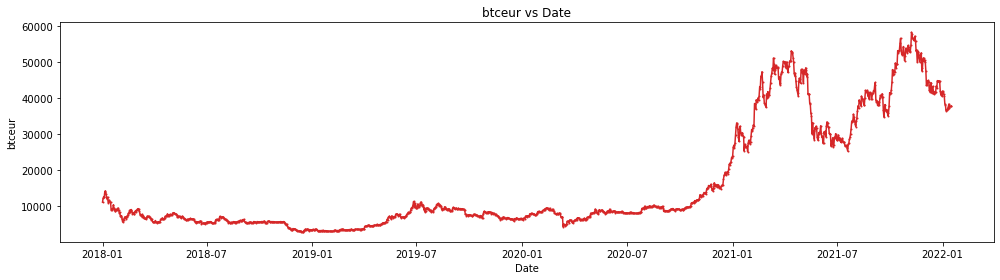

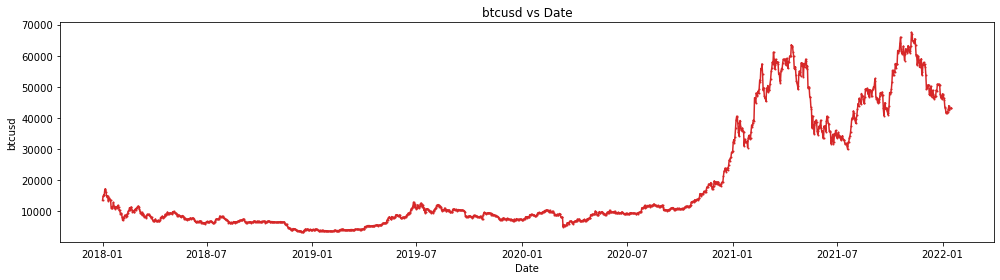

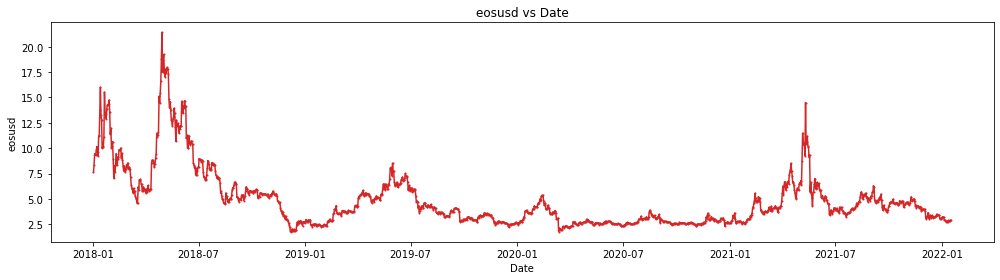

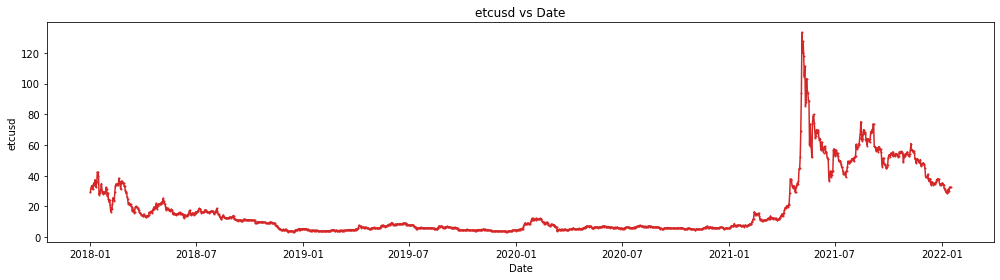

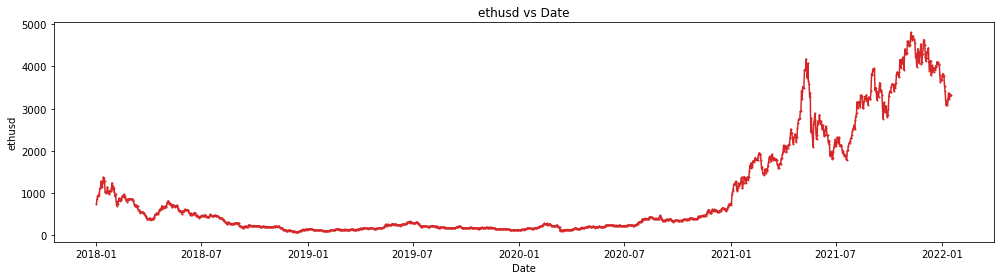

In [29]:
//Plot daily price chart of top 5 the selected cryptocurrency pairs
plotCryptoDaily[;2018.01.01;.z.D] each 5#syms;

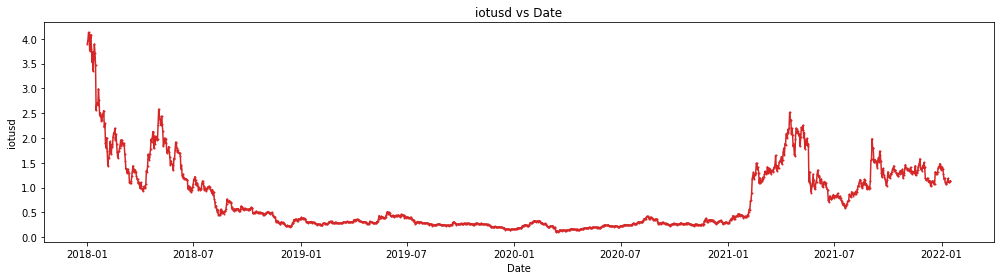

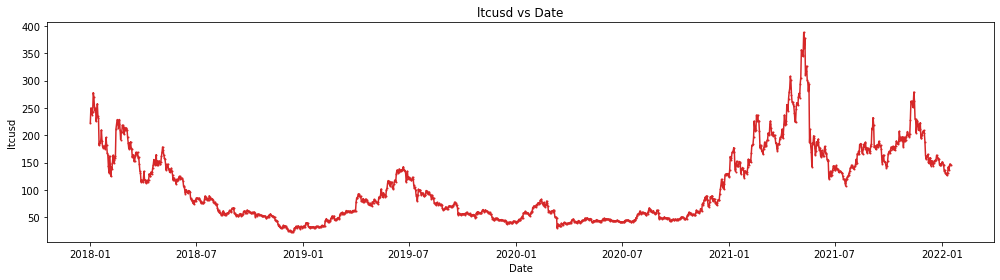

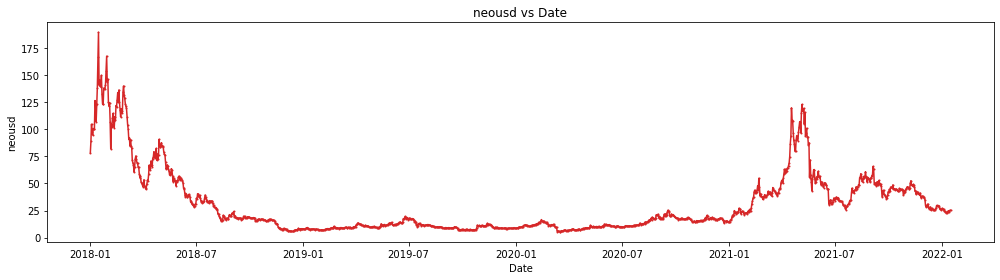

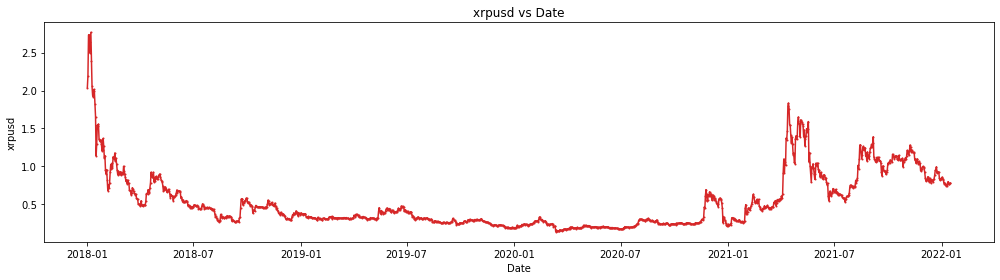

In [30]:
//Plot daily price chart of last 4 the selected cryptocurrency pairs
plotCryptoDaily[;2018.01.01;.z.D] each -4#syms;

## Cross Correlation ##

### Cross correlation ###

In [31]:
// @functionoverview Computes daily log return of the specified symbol within start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl}  daily log return keyed by date
getDailyReturn:{[symbol;sd;ed] 
    data:select from dailyTbl where date within (sd;ed), sym=symbol;
    data:update ret1d:log[close%prev close] from data;
    data:`date xkey (`date;symbol) xcol select date, ret1d from data;
    :1_data;};

In [34]:
// @functionoverview Computes cross correlation of symbols specified using daily returns  
// @param syms {list} list of cryptocurrency symbols
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl}  cross correlation table
computeCrossCorr:{[syms;sd;ed]
    retTbl:(lj/)getDailyReturn[;sd;ed] each syms;
    cyptocorr:r cor/:\:r:(enlist `date) _flip 0!retTbl;
    cyptocorr:`sym xkey update sym: key cyptocorr from value flip cyptocorr;
    :cyptocorr;};

#### Cross correlation of daily return   ####

#### Year 2018   ####

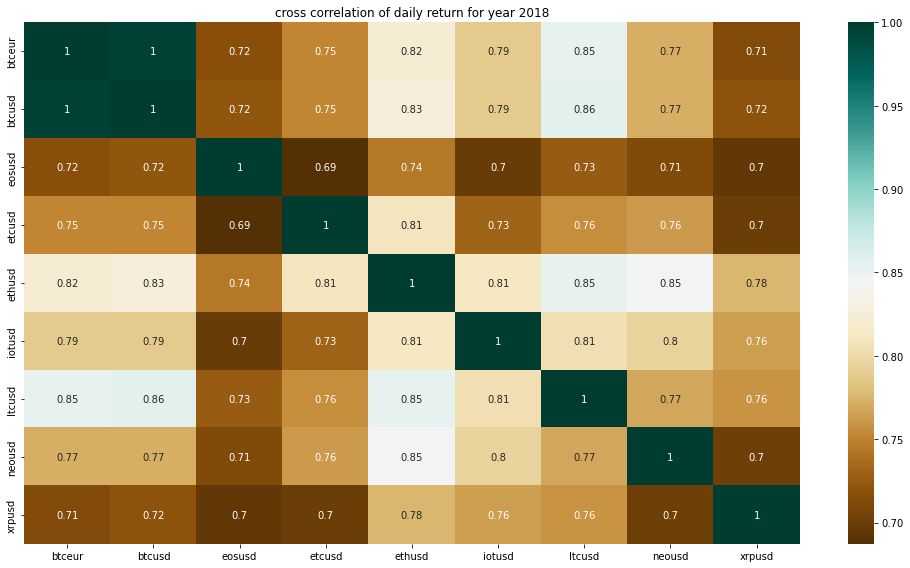

In [33]:
cyptocorr:computeCrossCorr[syms;2018.01.01;2018.12.31];
.util.plotHeatMap[cyptocorr;"cross correlation of daily return for year 2018"];

#### year 2019   ####

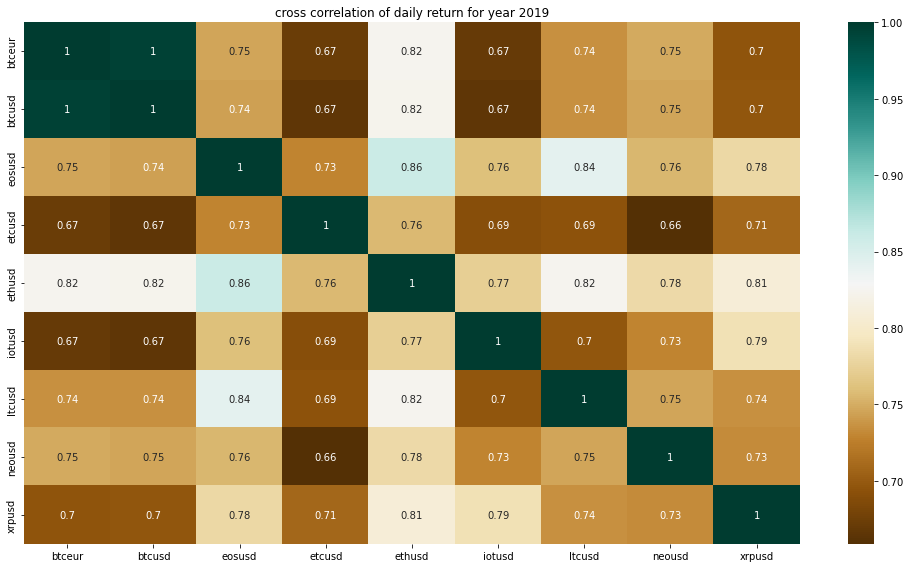

In [35]:
cyptocorr:computeCrossCorr[syms;2019.01.01;2019.12.31];
.util.plotHeatMap[cyptocorr;"cross correlation of daily return for year 2019"];

##### Observation: ######
There is a significant cross-correlation between multiple pairs of crypto currencies.

### Auto correlation of daily return ###

In [36]:
//compute daily return for ploting ACF
retTbl:(lj/)getDailyReturn[;2018.01.01;2018.12.31] each syms;
retTbl:(enlist `date) _flip 0!retTbl;

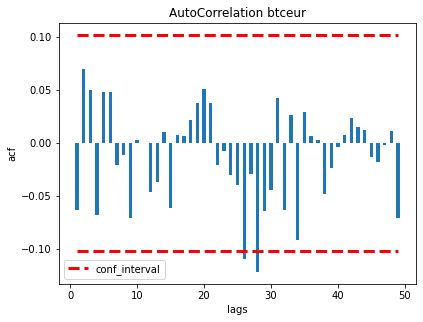

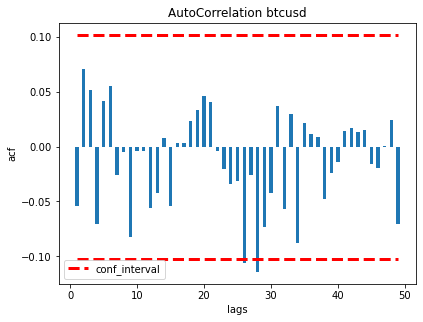

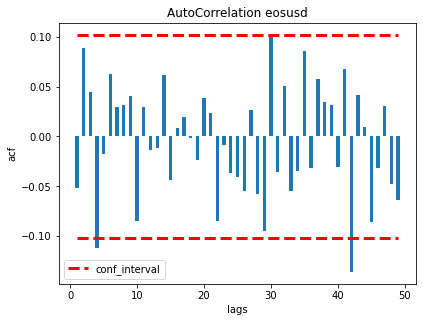

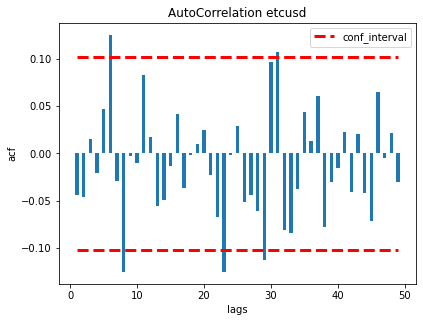

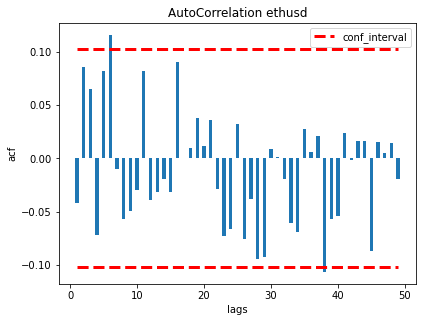

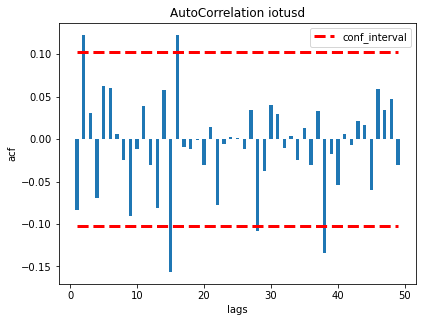

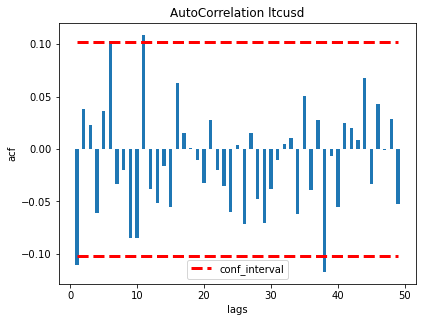

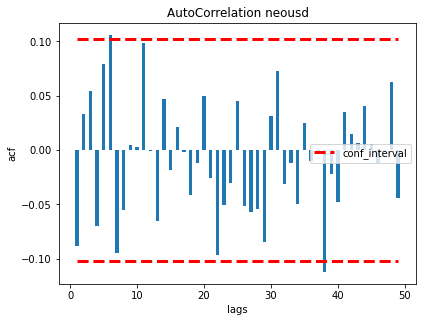

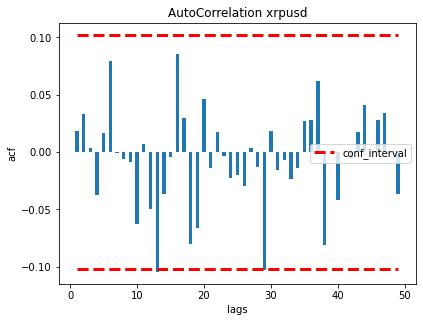

In [37]:
// plot acf for all crypto currencies
{.ml.ts.acfPlot[retTbl x;50;1; string[x]]} each syms;

### Partial Auto correlation of daily return ###

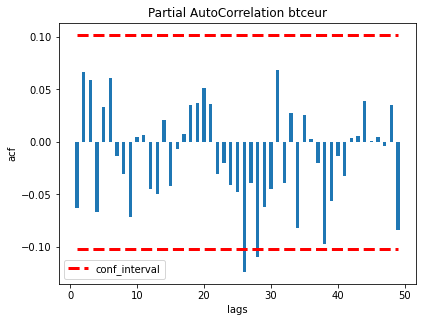

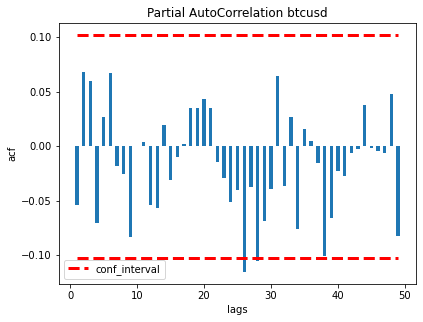

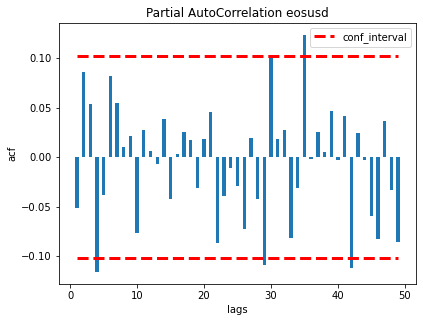

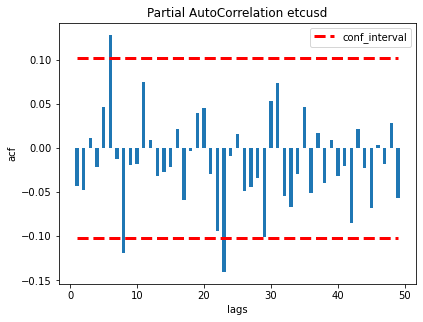

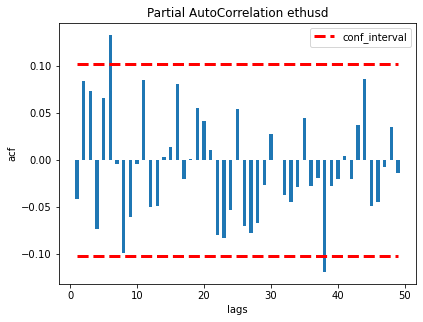

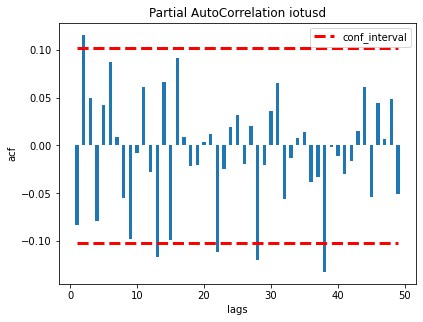

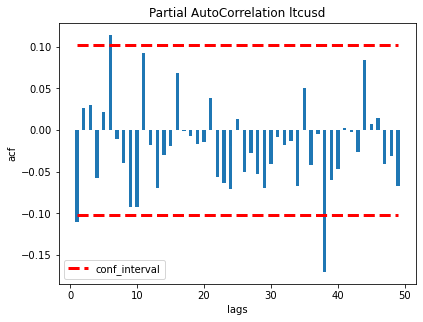

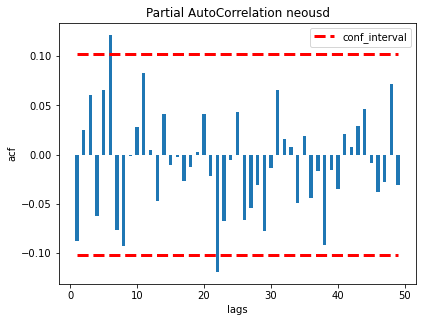

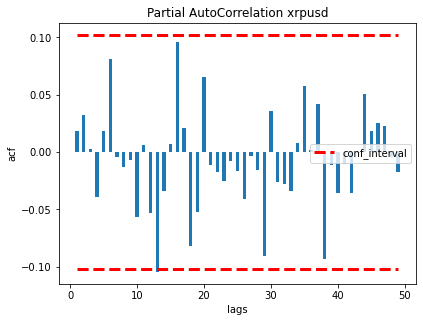

In [38]:
// plaot pacf for all crypto currencies
{.ml.ts.pacfPlot[retTbl x;50;1; string[x]]} each syms;

### Methodology ###

The data set is divided into number of training sets and trading sets on a rolling basis. The training data set uses past one year of data and trading data set contains 1 month of future data. Features are generated for the respective training periods to capture the characteristics of individual crypto currency pairs. Subsequently, the Random Forest Classifier is trained on the training set to make predictions in the sebsequent trading period (1 month in our case). 

We designed following feature sets to estimate direction on the susequent day:

1. 1, 5, 10, 20, 40, 60 and 120 day log return
2. daily return volatility using 10, 20, 40, 60 and 120 days 
3. Volume ratio: Volume/20 Day ADV, 20 Day ADV/40 Day ADV, 40 Day ADV/60 Day ADV and 60 Day ADV/120 Day ADV
4. Avg Turnover using 20, 40, 60 and 120 days
5. Volatility of volume using 20, 40, 60 and 120 days

The target set contains following data set:
1. Classification: 1 if next day is up day or 0 if next day is down day

In [42]:
// @functionoverview Generates forward 1-day return for specified symbol within start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl} table containing 1-day return keyed by sym and date 
generateTargetData:{[symbol;sd;ed]
  data:select from dailyTbl where sym=symbol;
  data:select sym:symbol, date, retfwd:log xprev[neg 1;close]%close, targetcol:log xprev[neg 1;close]%close from data;
  data:select from data where not null retfwd;
  data:select from data where date within (sd;ed);
  data: `sym`date xkey data;
  :data;};

In [49]:
// @functionoverview Generates classification based on targetcol in the input tbl
// @param targetTbl {tbl} table containing target column
// @returns {tbl} updated input table with classification column 
generateUpDownClassification:{[targetTbl]
 :update class:?[targetcol>0;1;0] from targetTbl;};

In [44]:
// Not used
// @functionoverview Generates classification based on targetcol in the input tbl
// @param targetTbl {tbl} table containing target column
// @returns {tbl} updated input table with classification column based on cross sectional return 
generateCrossSectionalClassification:{[targetTbl]
 toprank: -1 + floor 0.8*count syms;
 :update class:?[toprank < rank targetcol;1;0] by date from targetTbl;};

In [45]:
// @functionoverview Generates feature set for specified symbol wthin start date and end date
// @param symbol {symbol} cryptocurrency symbol
// @param sd {date} start date 
// @param ed {date} end date 
// @returns {tbl} table containing momentum, volatility, volume, turnover features keyed by sym and date 
generateFeaturesData:{[symbol;sd;ed]
  // select price and volume data for the specified symbol
  data:select from dailyTbl where sym=symbol;

  // Add returns for 1,5,10,20,60,120 days
  data:update ret1: (log close%xprev[1;close]),
    ret5:(log close%xprev[5;close]),
    ret10:(log close%xprev[10;close]),
    ret20:(log close%xprev[20;close]),
    ret40:(log close%xprev[40;close]),
    ret60:(log close%xprev[60;close]),
    ret120:(log close%xprev[120;close]) from data;

  // Add 1-day return volatilities for 10,20,40,60,120 days
  data:update std10:mdev[10;ret1], 
    std20:mdev[20;ret1], 
    std40:mdev[40;ret1],
    std60:mdev[60;ret1],
    std120:mdev[120;ret1] from data;

  // Add volume acceleration features
  data:update volumeratio:volume%mavg[20;volume],
    volume20ratio:mavg[20;volume]%mavg[40;volume],
    volume40ratio:mavg[40;volume]%mavg[60;volume],
    volume60ratio:mavg[60;volume]%mavg[120;volume] from data;

  // Add avg turnover 
  data:update turnover20:mavg[20;volume*close],
    turnover40:mavg[60;volume*close],
    turnover60:mavg[80;volume*close],
    turnover120:mavg[120;volume*close] from data;

  //Add volume volatility
  data:update stdvolume20:mdev[20;volume], 
    stdvolume40:mdev[40;volume],
    stdvolume60:mdev[60;volume],
    stdvolume120:mdev[120;volume] from data;
  
  // remove days with null feature values
  data:select from data where not null ret120, not null std120, not null volume60ratio, not null turnover120, not null stdvolume120;
  
  // select dates within the start date and end date range
  data:select from data where date within (sd;ed);

  // Remove all the columns (price and volume) except feature columns
  data:delete open, close, high, low, volume from data;

  // Add sym and date key
  data:`sym`date xkey data;
  :data;};

In [46]:
// @functionoverview Generates dict containing target and feature tabls for both traning and testing set
// @param data {tbl} table containing target and feature columns
// @param splitdt {date} split date for training and testing split
// @returns {dict} returns dict containing target and feature tabls for both traning and testing set
trainTestSplit: {[data;splitdt]
    // Generate training data using date < split date
    trainData:select from data where date < splitdt;
    // delete all columns except feature columns
    xtrain: delete sym, date, retfwd, targetcol, class from trainData;
    xtrain: flip value flip xtrain;
    // populate target with classification
    ytrain: select class from trainData;
    show select count i by class from ytrain;
    ytrain: flip value flip ytrain;
    
     // Generate testing data using date >= split date
    testData:select from data where date >= splitdt;
    // delete all columns except feature columns
    xtest: delete sym, date, retfwd, targetcol, class from testData;
    xtest: flip value flip xtest;
    // populate target with classification
    ytest: select class from testData;
    show select count i by class from ytest;
    ytest: flip value flip ytest;

    //return dictionary containing training and testing data
    :(`xtrain`ytrain`xtest`ytest)!(xtrain;ytrain;xtest;ytest);};

In [47]:
// @functionoverview Generates score for performance comparison for various models
// @param yact {list} actual value of target 
// @param ypred {list} predicted value of target 
// @param yprob {list} probability of all classification 
// @returns {dict} returns dict containing log loss score, accuracy score and roc auc score
score:{[yact;ypred;yprob]
 `loss`acc`auc!(last .ml.logLoss[yact;yprob];last .ml.accuracy[ypred;yact];.ml.rocAucScore[raze yact;yprob[;1]])};

In [48]:
// @functionoverview Trains RF classifier, estimates forecasts for next day, validates the accuracy
// @param syms {list} list of symbol
// @param sd {date} start date of the trading period 
// @param ed {date} end date of the trading period 
// @param trainingDays {int} Number of days before sd to train RF  
// @returns {tbl} table containing date, sym and up probability for the next day
generateSignal:{[syms;sd;ed;trainingDays]
    // Compute training start date starting from 2018.01.01
    trnsd: 2018.01.01|sd-trainingDays;
    
    // Print training and testing periods
    -1 "::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::";
    -1 "Training Start Date: ", string[trnsd], " ", "Trading End Date: ", string[sd-1];
    -1 "Testing Start Date: ", string[sd], " ", "Testing End Date: ", string[ed];
    // Generate target data for all the cyptocurrency
    targetData: (uj/) generateTargetData[;trnsd;ed] each syms;

    // Generate classification based on the target feature is postive or negative
    targetData: generateUpDownClassification[targetData];
    //targetData: generateCrossSectionalClassification[targetData];

    // Generate features data
    featureData: (uj/)generateFeaturesData[;trnsd;ed] each syms;
    
    // remove dates if not present in both target tbl or features tbl
    data:0!ij[targetData;featureData];
    
    //generate training and testing data
    -1 "Training and testing row count: ";
    datadict:trainTestSplit[data;sd];
    show count each datadict;

    //Random forest classifier setting
    name:"Random Forest Classifier";
    ntrees:100;
    clfkwargs:`class_weight`max_depth!(`balanced;5);
    clf:.p.import[`sklearn.ensemble]`:RandomForestClassifier;
    clf:clf[`n_estimators pykw ntrees;pykwargs clfkwargs];
 
    //Random forest fit
    clf[`:fit][xnp:.util.npa datadict`xtrain;datadict`ytrain];
    
    //Probability estimation
    ytrnprob:clf[`:predict_proba;<;xnp];
    ytrnpred:{x?max x} each ytrnprob;
    ytstprob:clf[`:predict_proba;<;.util.npa datadict`xtest];
    ytstpred:{x?max x} each ytstprob;
    
    //Genrate model performance score
    trnscore:score[datadict`ytrain;ytrnpred;ytrnprob];
    tstscore:score[datadict`ytest ;ytstpred;ytstprob];
    
    //Show feature importance
    -1"\n",":Top 10 features:";
    featurecolnames:(cols featureData) except `sym`date;
    show 10#desc (feature:featurecolnames)!(importance:clf[`:feature_importances_]`);
    
    .util.displayROC[raze datadict`ytest;ytstprob[;1]];
    -1 name," (",string[ntrees]," trees)";
    -1 "Training log loss: ",string[trnscore`loss],", accuracy: ",string[trnscore`acc],", ROC: ",string trnscore`auc;
    -1 "Testing  log loss: ",string[tstscore`loss],", accuracy: ",string[tstscore`acc],", ROC: ",string tstscore`auc;
    -1"\n";
    
    signalData: `date`sym xkey select date, sym,  retfwd, probUp:ytstprob[;1] from data where sd <=date;

    :signalData;};


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.01.01 Trading End Date: 2018.12.31
Testing Start Date: 2019.01.01 Testing End Date: 2019.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 1733
1    | 1548
class| x  
-----| ---
0    | 157
1    | 122
xtrain| 3281
ytrain| 3281
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1638185
ret40        | 0.06990242
ret5         | 0.06424777
volume40ratio| 0.04993644
volumeratio  | 0.04988565
ret120       | 0.04695185
ret20        | 0.04693544
ret10        | 0.04526266
ret60        | 0.04134288
std10        | 0.03786945


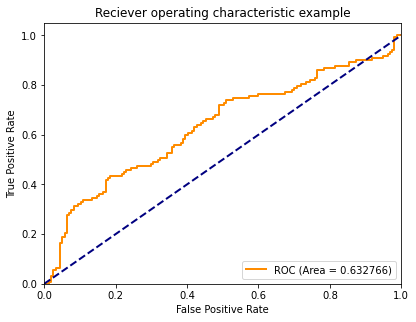

Random Forest Classifier (100 trees)
Training log loss: 0.6394772, accuracy: 0.7019201, ROC: 0.780293
Testing  log loss: 0.6697631, accuracy: 0.6344086, ROC: 0.632766


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.02.01 Trading End Date: 2019.01.31
Testing Start Date: 2019.02.01 Testing End Date: 2019.02.28
Training and testing row count: 
class| x   
-----| ----
0    | 1754
1    | 1531
class| x  
-----| ---
0    | 104
1    | 148
xtrain| 3285
ytrain| 3285
xtest | 252
ytest | 252

:Top 10 features:
ret1         | 0.1842706
ret40        | 0.07254502
ret10        | 0.06232925
ret5         | 0.05815937
ret120       | 0.051651
volume40ratio| 0.05101181
volumeratio  | 0.04415023
std10        | 0.04396256
std20        | 0.03950622
ret60        | 0.03689217


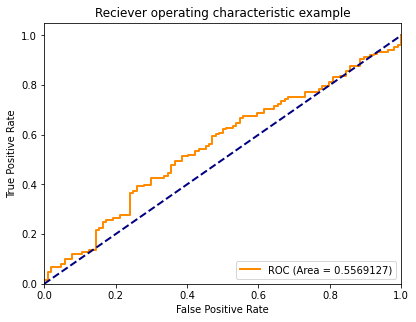

Random Forest Classifier (100 trees)
Training log loss: 0.6335763, accuracy: 0.6931507, ROC: 0.7789064
Testing  log loss: 0.7245815, accuracy: 0.452381, ROC: 0.5569127


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.03.01 Trading End Date: 2019.02.28
Testing Start Date: 2019.03.01 Testing End Date: 2019.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 1737
1    | 1548
class| x  
-----| ---
0    | 139
1    | 140
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1889862
ret120       | 0.07604387
std60        | 0.0605292
ret40        | 0.05802123
ret20        | 0.04768032
volume40ratio| 0.04575656
ret5         | 0.04525152
std10        | 0.04295837
std40        | 0.03393535
volumeratio  | 0.033553


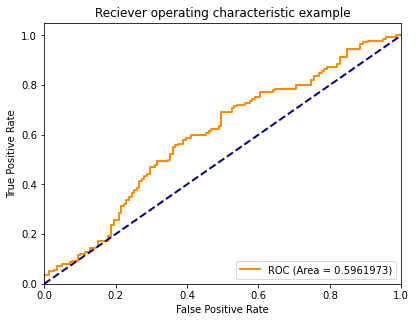

Random Forest Classifier (100 trees)
Training log loss: 0.6385594, accuracy: 0.6898021, ROC: 0.7731945
Testing  log loss: 0.6831238, accuracy: 0.5806452, ROC: 0.5961973


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.04.01 Trading End Date: 2019.03.31
Testing Start Date: 2019.04.01 Testing End Date: 2019.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 1689
1    | 1596
class| x  
-----| ---
0    | 135
1    | 135
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2467634
ret40        | 0.06395952
ret5         | 0.05344439
ret60        | 0.05191272
volumeratio  | 0.05038999
std120       | 0.04282128
ret20        | 0.03850127
ret10        | 0.03813613
volume40ratio| 0.03440379
volume20ratio| 0.03440101


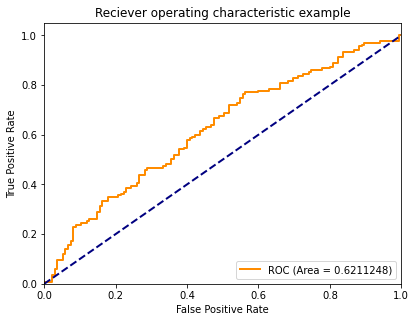

Random Forest Classifier (100 trees)
Training log loss: 0.6353802, accuracy: 0.6937595, ROC: 0.7701811
Testing  log loss: 0.6784525, accuracy: 0.5740741, ROC: 0.6211248


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.05.01 Trading End Date: 2019.04.30
Testing Start Date: 2019.05.01 Testing End Date: 2019.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 1723
1    | 1562
class| x  
-----| ---
0    | 128
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2550337
ret5         | 0.05739527
ret40        | 0.05539949
volumeratio  | 0.04967354
volume40ratio| 0.04475198
ret20        | 0.04296924
ret60        | 0.04275418
ret10        | 0.03860229
std60        | 0.0381903
ret120       | 0.0367307


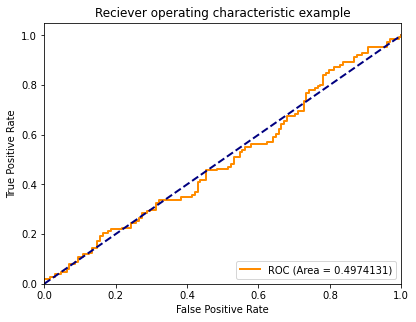

Random Forest Classifier (100 trees)
Training log loss: 0.6349475, accuracy: 0.6888889, ROC: 0.7659916
Testing  log loss: 0.7039819, accuracy: 0.4731183, ROC: 0.4974131


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.06.01 Trading End Date: 2019.05.31
Testing Start Date: 2019.06.01 Testing End Date: 2019.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 1693
1    | 1592
class| x  
-----| ---
0    | 112
1    | 158
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2432595
ret5         | 0.05138581
ret10        | 0.04870515
ret60        | 0.04695533
volume40ratio| 0.04675679
ret40        | 0.04439287
volumeratio  | 0.04423456
std60        | 0.03930573
std10        | 0.03925713
std20        | 0.03690779


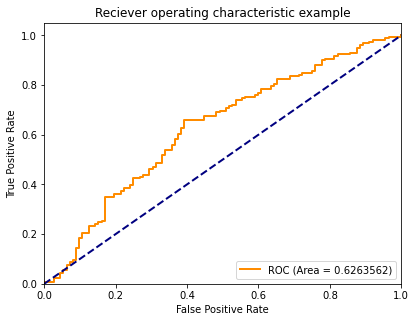

Random Forest Classifier (100 trees)
Training log loss: 0.6348116, accuracy: 0.6928463, ROC: 0.7694583
Testing  log loss: 0.6790673, accuracy: 0.5666667, ROC: 0.6263562


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.07.01 Trading End Date: 2019.06.30
Testing Start Date: 2019.07.01 Testing End Date: 2019.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 1665
1    | 1620
class| x  
-----| ---
0    | 143
1    | 136
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2081653
ret10        | 0.05451857
ret60        | 0.05447915
volume40ratio| 0.0507996
ret20        | 0.05079746
ret40        | 0.04995081
ret120       | 0.04685944
std120       | 0.04315749
volumeratio  | 0.04244511
ret5         | 0.03883302


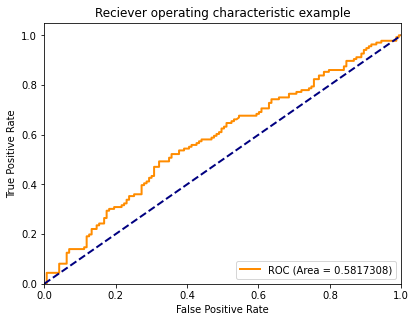

Random Forest Classifier (100 trees)
Training log loss: 0.6368156, accuracy: 0.6879756, ROC: 0.7644574
Testing  log loss: 0.6837338, accuracy: 0.5663082, ROC: 0.5817308


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.08.01 Trading End Date: 2019.07.31
Testing Start Date: 2019.08.01 Testing End Date: 2019.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 1655
1    | 1630
class| x  
-----| ---
0    | 154
1    | 125
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2189242
ret60        | 0.05965626
ret5         | 0.05214912
ret10        | 0.05146954
volume40ratio| 0.05108952
ret20        | 0.04922647
ret40        | 0.03981288
std120       | 0.03846847
ret120       | 0.03497031
std10        | 0.03445166


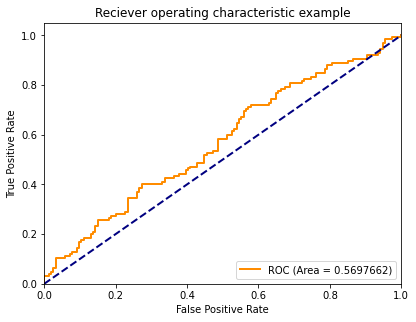

Random Forest Classifier (100 trees)
Training log loss: 0.6366406, accuracy: 0.6882801, ROC: 0.7689311
Testing  log loss: 0.6840811, accuracy: 0.5268817, ROC: 0.5697662


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.09.01 Trading End Date: 2019.08.31
Testing Start Date: 2019.09.01 Testing End Date: 2019.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 1662
1    | 1623
class| x  
-----| ---
0    | 150
1    | 120
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2119024
ret10        | 0.0621161
ret5         | 0.05896535
volume40ratio| 0.05314045
ret40        | 0.04855685
ret20        | 0.04690642
ret60        | 0.04388027
std120       | 0.03894486
std10        | 0.03892802
volumeratio  | 0.03774109


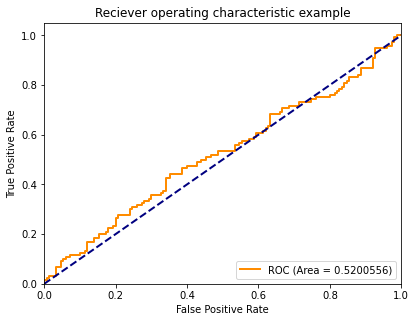

Random Forest Classifier (100 trees)
Training log loss: 0.6358638, accuracy: 0.7038052, ROC: 0.7750233
Testing  log loss: 0.6930966, accuracy: 0.5407407, ROC: 0.5200556


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.10.01 Trading End Date: 2019.09.30
Testing Start Date: 2019.10.01 Testing End Date: 2019.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 1667
1    | 1618
class| x  
-----| ---
0    | 139
1    | 140
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1844466
ret60        | 0.06167812
ret5         | 0.06140736
ret10        | 0.05990378
ret20        | 0.05656193
volume40ratio| 0.05066825
std10        | 0.04729935
ret120       | 0.04608237
std120       | 0.04234503
volumeratio  | 0.04019832


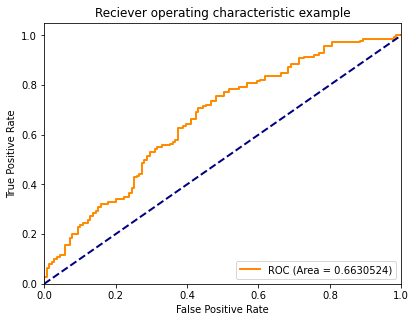

Random Forest Classifier (100 trees)
Training log loss: 0.6358187, accuracy: 0.7010654, ROC: 0.7816626
Testing  log loss: 0.6739803, accuracy: 0.5770609, ROC: 0.6630524


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.11.01 Trading End Date: 2019.10.31
Testing Start Date: 2019.11.01 Testing End Date: 2019.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 1655
1    | 1630
class| x  
-----| ---
0    | 149
1    | 121
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.2230487
ret5         | 0.06495884
volume40ratio| 0.06250375
ret10        | 0.05168653
ret60        | 0.04827775
std10        | 0.04710447
std120       | 0.04498514
ret20        | 0.04253252
ret120       | 0.0419034
ret40        | 0.03915159


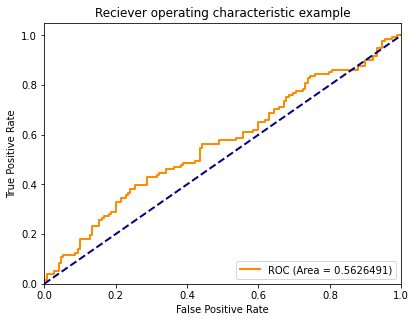

Random Forest Classifier (100 trees)
Training log loss: 0.6340176, accuracy: 0.7035008, ROC: 0.779772
Testing  log loss: 0.6904353, accuracy: 0.5, ROC: 0.5626491


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2018.12.01 Trading End Date: 2019.11.30
Testing Start Date: 2019.12.01 Testing End Date: 2019.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 1652
1    | 1633
class| x  
-----| ---
0    | 149
1    | 130
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1912354
ret10        | 0.07078952
volume40ratio| 0.06295384
ret5         | 0.06037641
ret20        | 0.05737994
ret60        | 0.05143679
std20        | 0.048344
ret40        | 0.04537356
ret120       | 0.04414894
std10        | 0.03915762


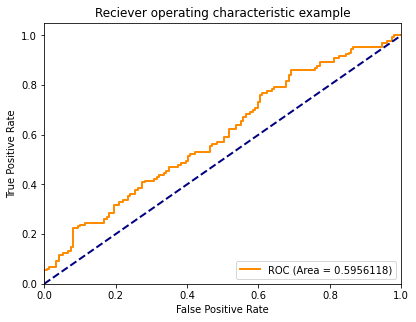

Random Forest Classifier (100 trees)
Training log loss: 0.6352114, accuracy: 0.7010654, ROC: 0.7757401
Testing  log loss: 0.6790412, accuracy: 0.5591398, ROC: 0.5956118


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.01.01 Trading End Date: 2019.12.31
Testing Start Date: 2020.01.01 Testing End Date: 2020.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 1659
1    | 1626
class| x  
-----| ---
0    | 121
1    | 158
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1  | 0.1899466
ret10 | 0.08172143
ret20 | 0.07235107
ret5  | 0.06794217
ret60 | 0.05569391
std20 | 0.05547987
ret120| 0.04370197
ret40 | 0.04211778
std60 | 0.03816749
std10 | 0.0371648


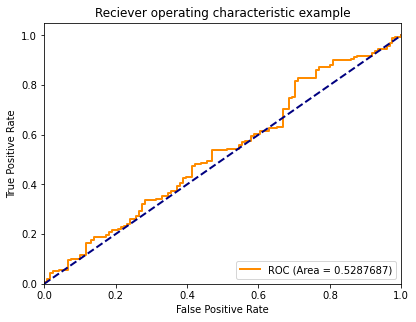

Random Forest Classifier (100 trees)
Training log loss: 0.6362755, accuracy: 0.699239, ROC: 0.77417
Testing  log loss: 0.701005, accuracy: 0.483871, ROC: 0.5287687


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.02.01 Trading End Date: 2020.01.31
Testing Start Date: 2020.02.01 Testing End Date: 2020.02.29
Training and testing row count: 
class| x   
-----| ----
0    | 1623
1    | 1662
class| x  
-----| ---
0    | 130
1    | 131
xtrain| 3285
ytrain| 3285
xtest | 261
ytest | 261

:Top 10 features:
ret1         | 0.1567787
ret10        | 0.08054059
ret5         | 0.07159628
std20        | 0.06139107
ret20        | 0.05654997
ret120       | 0.0495977
volumeratio  | 0.04364401
std60        | 0.04085462
ret60        | 0.04008383
volume40ratio| 0.03701601


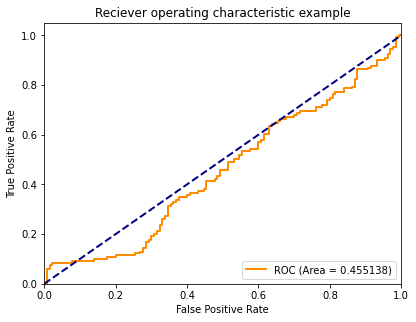

Random Forest Classifier (100 trees)
Training log loss: 0.6393932, accuracy: 0.6937595, ROC: 0.7812153
Testing  log loss: 0.7093983, accuracy: 0.48659, ROC: 0.455138


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.03.02 Trading End Date: 2020.02.29
Testing Start Date: 2020.03.01 Testing End Date: 2020.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 1643
1    | 1642
class| x  
-----| ---
0    | 129
1    | 150
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1221132
ret10        | 0.07101183
std20        | 0.06651414
ret5         | 0.06165251
ret20        | 0.05743518
volume40ratio| 0.0570669
ret40        | 0.04655853
std120       | 0.04411758
ret120       | 0.03897563
volumeratio  | 0.03883638


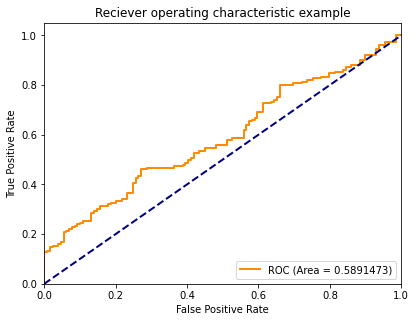

Random Forest Classifier (100 trees)
Training log loss: 0.6430573, accuracy: 0.6974125, ROC: 0.7838514
Testing  log loss: 0.6709759, accuracy: 0.5663082, ROC: 0.5891473


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.04.02 Trading End Date: 2020.03.31
Testing Start Date: 2020.04.01 Testing End Date: 2020.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 1639
1    | 1646
class| x  
-----| ---
0    | 114
1    | 156
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1447395
ret10        | 0.06537397
std20        | 0.06126507
ret40        | 0.06037474
ret5         | 0.05842496
ret20        | 0.05674498
ret60        | 0.05360179
volume40ratio| 0.04462222
std10        | 0.04435287
std120       | 0.04196608


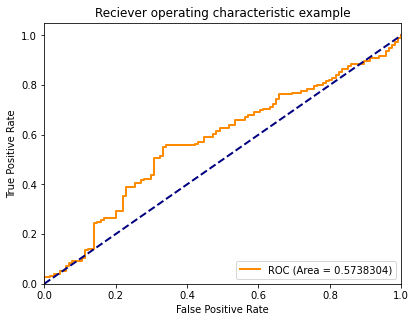

Random Forest Classifier (100 trees)
Training log loss: 0.6389512, accuracy: 0.6946728, ROC: 0.7814666
Testing  log loss: 0.6858462, accuracy: 0.5666667, ROC: 0.5738304


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.05.02 Trading End Date: 2020.04.30
Testing Start Date: 2020.05.01 Testing End Date: 2020.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 1614
1    | 1671
class| x  
-----| ---
0    | 130
1    | 149
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1460192
ret40        | 0.09312977
ret10        | 0.06658822
std20        | 0.06537121
ret5         | 0.0645454
ret60        | 0.05635527
ret20        | 0.05125929
volume20ratio| 0.04438568
volumeratio  | 0.04219898
std40        | 0.03964275


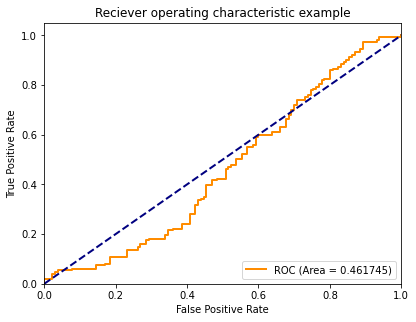

Random Forest Classifier (100 trees)
Training log loss: 0.6342823, accuracy: 0.7178082, ROC: 0.7942873
Testing  log loss: 0.7007446, accuracy: 0.5268817, ROC: 0.461745


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.06.02 Trading End Date: 2020.05.31
Testing Start Date: 2020.06.01 Testing End Date: 2020.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 1620
1    | 1665
class| x  
-----| ---
0    | 145
1    | 125
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.155691
ret40        | 0.08227393
std20        | 0.07268755
ret5         | 0.06518743
ret10        | 0.05336259
ret20        | 0.05218436
std10        | 0.04679412
ret60        | 0.04552878
volume20ratio| 0.04391274
volume40ratio| 0.03996241


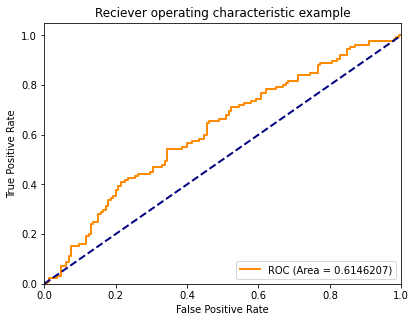

Random Forest Classifier (100 trees)
Training log loss: 0.6351143, accuracy: 0.7001522, ROC: 0.7847981
Testing  log loss: 0.6788076, accuracy: 0.5740741, ROC: 0.6146207


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.07.02 Trading End Date: 2020.06.30
Testing Start Date: 2020.07.01 Testing End Date: 2020.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 1647
1    | 1638
class| x  
-----| ---
0    | 122
1    | 157
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1511442
ret40        | 0.08436985
ret5         | 0.08415149
ret10        | 0.07111894
std20        | 0.06008428
ret60        | 0.05714753
ret20        | 0.05033221
std10        | 0.04907036
volume20ratio| 0.04131048
volumeratio  | 0.0402492


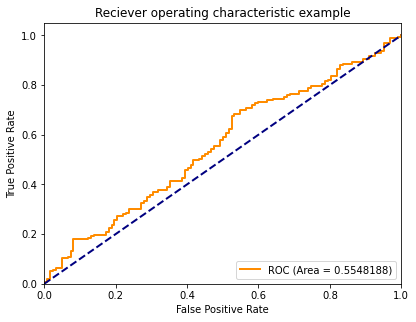

Random Forest Classifier (100 trees)
Training log loss: 0.6320926, accuracy: 0.7086758, ROC: 0.7912429
Testing  log loss: 0.7224597, accuracy: 0.4659498, ROC: 0.5548188


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.08.02 Trading End Date: 2020.07.31
Testing Start Date: 2020.08.01 Testing End Date: 2020.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 1625
1    | 1660
class| x  
-----| ---
0    | 125
1    | 154
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1554511
ret40        | 0.09649637
ret5         | 0.06735221
ret20        | 0.05529694
ret10        | 0.05432977
std20        | 0.04530343
ret60        | 0.0450521
volume20ratio| 0.04362231
std10        | 0.04069508
std60        | 0.03868064


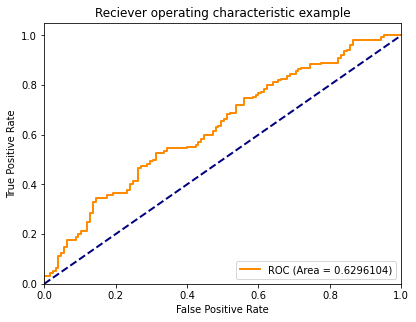

Random Forest Classifier (100 trees)
Training log loss: 0.6344069, accuracy: 0.7175038, ROC: 0.7962289
Testing  log loss: 0.6722313, accuracy: 0.5878136, ROC: 0.6296104


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.09.02 Trading End Date: 2020.08.31
Testing Start Date: 2020.09.01 Testing End Date: 2020.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 1603
1    | 1682
class| x  
-----| ---
0    | 130
1    | 140
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.191019
ret40        | 0.08729856
ret5         | 0.07148814
ret60        | 0.05289124
std20        | 0.05190928
volume20ratio| 0.05056963
ret10        | 0.05025786
ret20        | 0.03954325
volumeratio  | 0.03691865
std10        | 0.03666715


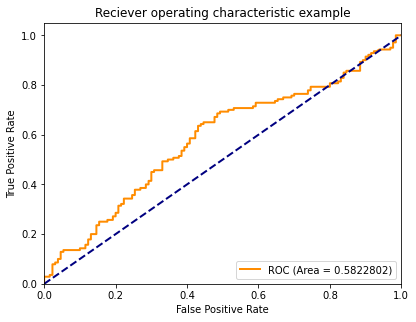

Random Forest Classifier (100 trees)
Training log loss: 0.6307034, accuracy: 0.7156773, ROC: 0.7885898
Testing  log loss: 0.6870154, accuracy: 0.562963, ROC: 0.5822802


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.10.02 Trading End Date: 2020.09.30
Testing Start Date: 2020.10.01 Testing End Date: 2020.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 1583
1    | 1702
class| x  
-----| ---
0    | 128
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.2384306
ret5         | 0.06537348
ret40        | 0.06427668
ret60        | 0.05995546
volume20ratio| 0.05624224
ret10        | 0.05209228
std20        | 0.04545822
std10        | 0.04426971
ret20        | 0.03790581
std40        | 0.03702156


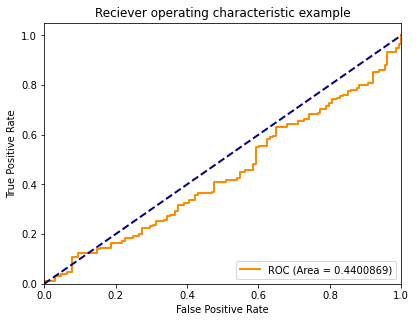

Random Forest Classifier (100 trees)
Training log loss: 0.6300126, accuracy: 0.6961948, ROC: 0.7792286
Testing  log loss: 0.7200765, accuracy: 0.4551971, ROC: 0.4400869


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.11.02 Trading End Date: 2020.10.31
Testing Start Date: 2020.11.01 Testing End Date: 2020.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 1568
1    | 1717
class| x  
-----| ---
0    | 119
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1945046
ret40        | 0.05917235
ret5         | 0.05655428
ret60        | 0.05603968
ret10        | 0.05356272
volume20ratio| 0.05353739
std10        | 0.04577457
ret20        | 0.039162
std60        | 0.0390809
std40        | 0.03812682


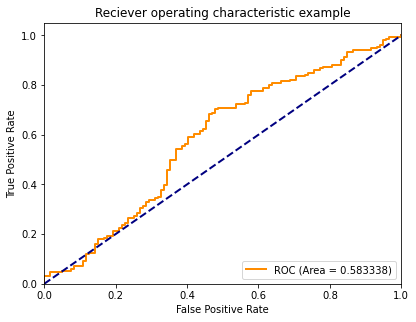

Random Forest Classifier (100 trees)
Training log loss: 0.6384028, accuracy: 0.6828006, ROC: 0.7773616
Testing  log loss: 0.6853873, accuracy: 0.5814815, ROC: 0.583338


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2019.12.02 Trading End Date: 2020.11.30
Testing Start Date: 2020.12.01 Testing End Date: 2020.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 1534
1    | 1751
class| x  
-----| ---
0    | 125
1    | 154
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1942833
ret5         | 0.07817954
ret40        | 0.06612025
ret60        | 0.0576239
ret20        | 0.04876992
volume20ratio| 0.04283316
ret10        | 0.04155709
std10        | 0.03741648
volume40ratio| 0.03684205
std120       | 0.03528719


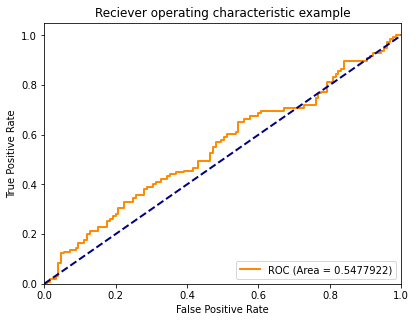

Random Forest Classifier (100 trees)
Training log loss: 0.6407247, accuracy: 0.6794521, ROC: 0.7713886
Testing  log loss: 0.6886626, accuracy: 0.5304659, ROC: 0.5477922


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.01.02 Trading End Date: 2020.12.31
Testing Start Date: 2021.01.01 Testing End Date: 2021.01.31
Training and testing row count: 
class| x   
-----| ----
0    | 1509
1    | 1776
class| x  
-----| ---
0    | 123
1    | 156
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1821521
ret40        | 0.06592676
ret5         | 0.05978018
ret60        | 0.05440446
std120       | 0.04744216
ret10        | 0.04307175
std10        | 0.04009529
volume20ratio| 0.03901026
volume60ratio| 0.0387135
std40        | 0.0354758


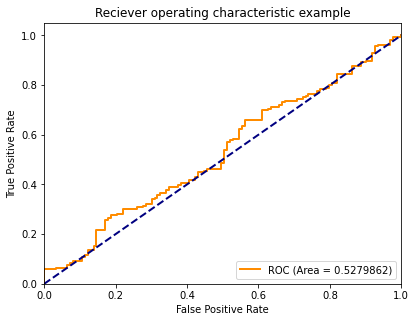

Random Forest Classifier (100 trees)
Training log loss: 0.6432524, accuracy: 0.6718417, ROC: 0.7660311
Testing  log loss: 0.6947981, accuracy: 0.4910394, ROC: 0.5279862


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.02.02 Trading End Date: 2021.01.31
Testing Start Date: 2021.02.01 Testing End Date: 2021.02.28
Training and testing row count: 
class| x   
-----| ----
0    | 1516
1    | 1769
class| x  
-----| ---
0    | 111
1    | 141
xtrain| 3285
ytrain| 3285
xtest | 252
ytest | 252

:Top 10 features:
ret1         | 0.182417
ret40        | 0.06975629
ret5         | 0.06438039
ret60        | 0.04260508
volume60ratio| 0.04164459
ret10        | 0.03991375
ret20        | 0.03963799
std40        | 0.03948321
std20        | 0.03940897
volume40ratio| 0.03873367


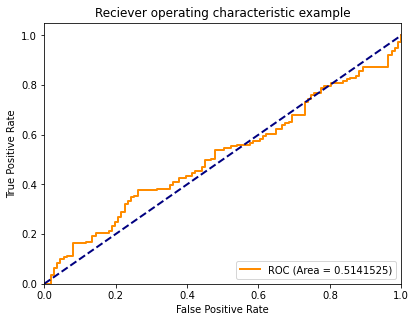

Random Forest Classifier (100 trees)
Training log loss: 0.6423466, accuracy: 0.6849315, ROC: 0.7710291
Testing  log loss: 0.6988303, accuracy: 0.515873, ROC: 0.5141525


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.03.01 Trading End Date: 2021.02.28
Testing Start Date: 2021.03.01 Testing End Date: 2021.03.31
Training and testing row count: 
class| x   
-----| ----
0    | 1501
1    | 1784
class| x  
-----| ---
0    | 116
1    | 163
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1963452
ret5         | 0.06711116
ret40        | 0.05230919
ret60        | 0.04697983
std10        | 0.04664563
ret10        | 0.04561499
volume20ratio| 0.04278641
volume40ratio| 0.03994557
ret20        | 0.03771528
volume60ratio| 0.03703467


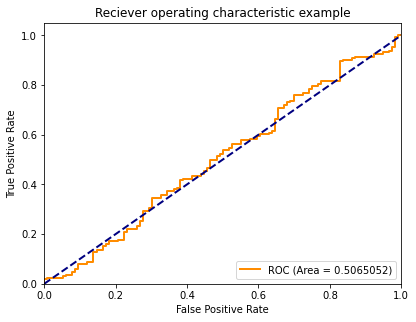

Random Forest Classifier (100 trees)
Training log loss: 0.6430887, accuracy: 0.6812785, ROC: 0.7723657
Testing  log loss: 0.6969898, accuracy: 0.4910394, ROC: 0.5065052


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.04.01 Trading End Date: 2021.03.31
Testing Start Date: 2021.04.01 Testing End Date: 2021.04.30
Training and testing row count: 
class| x   
-----| ----
0    | 1488
1    | 1797
class| x  
-----| ---
0    | 125
1    | 145
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1702999
ret5         | 0.07239211
ret40        | 0.0559047
volume40ratio| 0.04914903
ret10        | 0.04749903
std10        | 0.04519567
std40        | 0.04102497
ret60        | 0.03903533
ret120       | 0.03698305
volume60ratio| 0.03426682


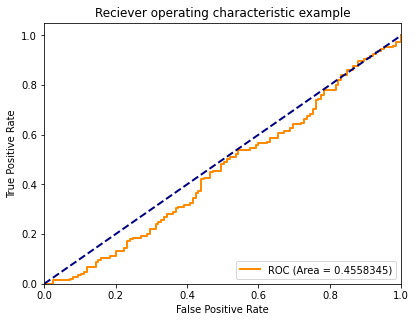

Random Forest Classifier (100 trees)
Training log loss: 0.6443953, accuracy: 0.6968037, ROC: 0.7719635
Testing  log loss: 0.7134712, accuracy: 0.4814815, ROC: 0.4558345


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.05.01 Trading End Date: 2021.04.30
Testing Start Date: 2021.05.01 Testing End Date: 2021.05.31
Training and testing row count: 
class| x   
-----| ----
0    | 1499
1    | 1786
class| x  
-----| ---
0    | 151
1    | 128
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1392974
ret40        | 0.05856228
ret5         | 0.05040519
std20        | 0.04661026
std60        | 0.04623682
volume20ratio| 0.04594426
ret120       | 0.04519504
std40        | 0.04260289
ret20        | 0.04236365
ret60        | 0.04040144


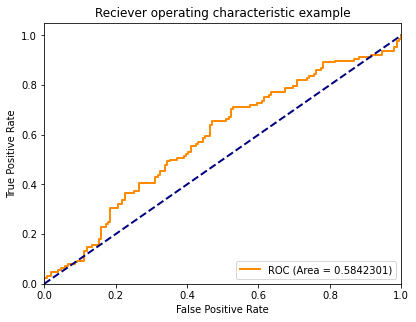

Random Forest Classifier (100 trees)
Training log loss: 0.6453729, accuracy: 0.7050228, ROC: 0.7854124
Testing  log loss: 0.6855677, accuracy: 0.5770609, ROC: 0.5842301


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.06.01 Trading End Date: 2021.05.31
Testing Start Date: 2021.06.01 Testing End Date: 2021.06.30
Training and testing row count: 
class| x   
-----| ----
0    | 1520
1    | 1765
class| x  
-----| ---
0    | 138
1    | 132
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1761378
ret5         | 0.05610263
ret40        | 0.04979899
std20        | 0.04785361
volume20ratio| 0.0463601
ret20        | 0.04502222
std120       | 0.04311055
std40        | 0.04237799
volume40ratio| 0.04063613
std60        | 0.0396124


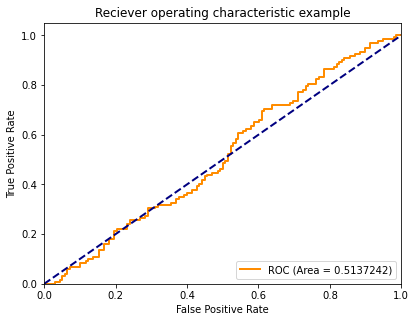

Random Forest Classifier (100 trees)
Training log loss: 0.646514, accuracy: 0.6809741, ROC: 0.766062
Testing  log loss: 0.6982986, accuracy: 0.5074074, ROC: 0.5137242


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.07.01 Trading End Date: 2021.06.30
Testing Start Date: 2021.07.01 Testing End Date: 2021.07.31
Training and testing row count: 
class| x   
-----| ----
0    | 1513
1    | 1772
class| x  
-----| ---
0    | 126
1    | 153
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1344535
ret5         | 0.06541641
ret60        | 0.05590841
std40        | 0.0541345
std20        | 0.05061523
ret40        | 0.04679959
volumeratio  | 0.04489504
ret20        | 0.04314507
std120       | 0.04141889
volume40ratio| 0.04059684


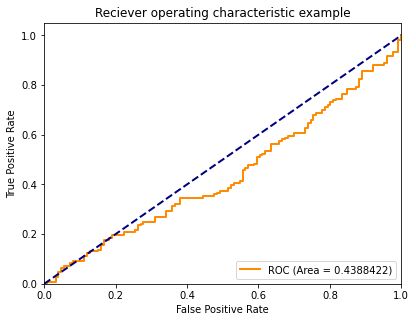

Random Forest Classifier (100 trees)
Training log loss: 0.6507189, accuracy: 0.6898021, ROC: 0.767438
Testing  log loss: 0.7048242, accuracy: 0.4336918, ROC: 0.4388422


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.08.01 Trading End Date: 2021.07.31
Testing Start Date: 2021.08.01 Testing End Date: 2021.08.31
Training and testing row count: 
class| x   
-----| ----
0    | 1517
1    | 1768
class| x  
-----| ---
0    | 117
1    | 162
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.1036567
ret5         | 0.0638132
std10        | 0.06024412
std20        | 0.05785171
std40        | 0.05173046
std60        | 0.04965306
volume20ratio| 0.04900386
volume60ratio| 0.04749573
ret40        | 0.04529482
volumeratio  | 0.04297985


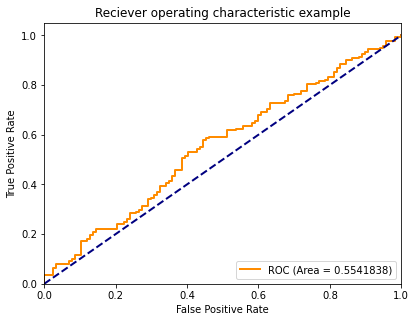

Random Forest Classifier (100 trees)
Training log loss: 0.6490028, accuracy: 0.7056317, ROC: 0.7730256
Testing  log loss: 0.6788109, accuracy: 0.5842294, ROC: 0.5541838


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.09.01 Trading End Date: 2021.08.31
Testing Start Date: 2021.09.01 Testing End Date: 2021.09.30
Training and testing row count: 
class| x   
-----| ----
0    | 1509
1    | 1776
class| x  
-----| ---
0    | 139
1    | 131
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.1142793
volume20ratio| 0.05929345
std20        | 0.05872408
ret5         | 0.05558542
ret20        | 0.05489226
std60        | 0.04980075
std10        | 0.04684077
ret120       | 0.0467158
std40        | 0.0446907
volumeratio  | 0.04341224


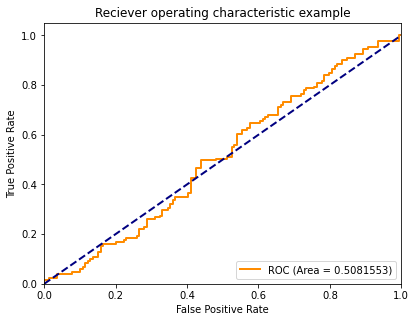

Random Forest Classifier (100 trees)
Training log loss: 0.6478173, accuracy: 0.6998478, ROC: 0.7731848
Testing  log loss: 0.6999746, accuracy: 0.5148148, ROC: 0.5081553


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.10.01 Trading End Date: 2021.09.30
Testing Start Date: 2021.10.01 Testing End Date: 2021.10.31
Training and testing row count: 
class| x   
-----| ----
0    | 1518
1    | 1767
class| x  
-----| ---
0    | 128
1    | 151
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1         | 0.09025549
ret5         | 0.06176597
std20        | 0.05817503
ret120       | 0.05543242
ret20        | 0.05519691
std40        | 0.04985264
volume20ratio| 0.04660069
std60        | 0.04640828
std10        | 0.04590265
ret10        | 0.04466526


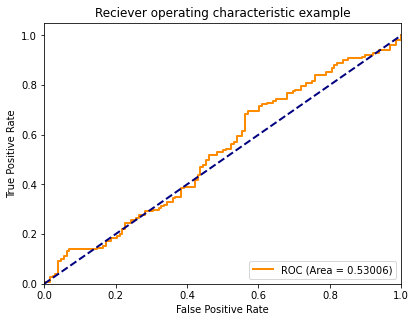

Random Forest Classifier (100 trees)
Training log loss: 0.6509029, accuracy: 0.6998478, ROC: 0.7780097
Testing  log loss: 0.6902533, accuracy: 0.5591398, ROC: 0.53006


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.11.01 Trading End Date: 2021.10.31
Testing Start Date: 2021.11.01 Testing End Date: 2021.11.30
Training and testing row count: 
class| x   
-----| ----
0    | 1518
1    | 1767
class| x  
-----| ---
0    | 129
1    | 141
xtrain| 3285
ytrain| 3285
xtest | 270
ytest | 270

:Top 10 features:
ret1         | 0.09937976
std20        | 0.05905788
ret5         | 0.05708175
std60        | 0.05288069
ret10        | 0.05248897
volumeratio  | 0.0504682
std10        | 0.04918557
ret40        | 0.0457126
volume60ratio| 0.04515073
volume40ratio| 0.04507224


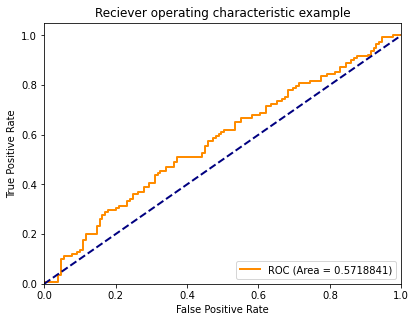

Random Forest Classifier (100 trees)
Training log loss: 0.6492183, accuracy: 0.7004566, ROC: 0.7788604
Testing  log loss: 0.6856608, accuracy: 0.5481481, ROC: 0.5718841


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2020.12.01 Trading End Date: 2021.11.30
Testing Start Date: 2021.12.01 Testing End Date: 2021.12.31
Training and testing row count: 
class| x   
-----| ----
0    | 1528
1    | 1757
class| x  
-----| ---
0    | 146
1    | 133
xtrain| 3285
ytrain| 3285
xtest | 279
ytest | 279

:Top 10 features:
ret1       | 0.1143889
std20      | 0.06283218
ret5       | 0.05980135
ret20      | 0.05261304
volumeratio| 0.05225185
ret40      | 0.05190011
std60      | 0.05125899
ret10      | 0.04556532
ret120     | 0.04185091
ret60      | 0.04157287


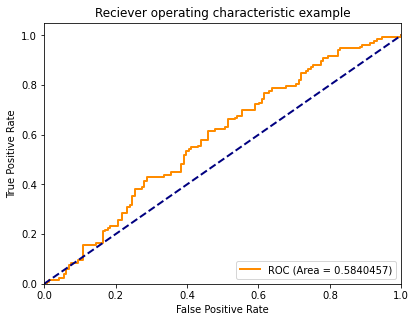

Random Forest Classifier (100 trees)
Training log loss: 0.6475195, accuracy: 0.7016743, ROC: 0.7760558
Testing  log loss: 0.6925764, accuracy: 0.5483871, ROC: 0.5840457


::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Training Start Date: 2021.01.01 Trading End Date: 2021.12.31
Testing Start Date: 2022.01.01 Testing End Date: 2022.01.16
Training and testing row count: 
class| x   
-----| ----
0    | 1549
1    | 1736
class| x 
-----| --
0    | 71
1    | 64
xtrain| 3285
ytrain| 3285
xtest | 135
ytest | 135

:Top 10 features:
ret1       | 0.118206
volumeratio| 0.07021438
std20      | 0.05588823
ret5       | 0.0512243
ret20      | 0.04949674
ret120     | 0.04739339
std10      | 0.04686694
std60      | 0.04478218
ret10      | 0.04461358
ret60      | 0.04318895


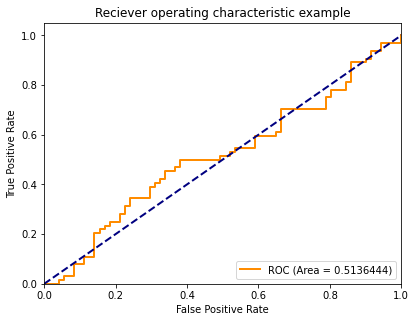

Random Forest Classifier (100 trees)
Training log loss: 0.6487879, accuracy: 0.6864536, ROC: 0.7767777
Testing  log loss: 0.6992621, accuracy: 0.4740741, ROC: 0.5136444




In [50]:
// run backtest to generate signal
// Generate tbl of inputs (list of sym, sd, ed, trainingDays) to call signal generation
backtestTbl: 0!select syms:syms, 
    sd:first date, 
    ed:last date by `month$date, trainingDays:365 from dailyTbl 
    where date >= 2019.01.01;
// Call the signal generation
signalTbl: (uj/) {generateSignal[x[`syms];x[`sd];x[`ed];x[`trainingDays]]} each backtestTbl;

In [51]:
// @functionoverview Generate pnl stats
// @param signalTbl {tbl} signal table
// @returns {tbl} backtest pnl stats and equity curve
getPnlSummary:{[signalTbl]
    signalTbl:update pos:?[0.52<probUp;1;?[0.48>probUp;-1;0]] by date from signalTbl;
    dailypnlTbl:select totalret:sum pos*retfwd, nassetlong: sum ?[0<pos;1;0], nassetshort: sum ?[pos<0;1;0] by date from signalTbl;
    dailypnlTbl:update nasset: nassetlong + nassetshort from dailypnlTbl;
    dailypnlTbl:update ret: totalret%nasset from dailypnlTbl;
    show select avgret: avg ret, 
        sdret: dev ret, 
        sharperatio: (avg ret)*sqrt(252)%dev ret, 
        minret:min ret, 
        maxret:max ret from dailypnlTbl;
    .util.plotTimeSeriesSubplots[exec date from dailypnlTbl;exec sums ret from dailypnlTbl;"cumulative pnl"];};

In [223]:
// Not used
getPnlSummaryCrossSectional:{[signalTbl]
    toprank: -1 + floor 0.8*count syms;
    bottomrank: -1 + (count syms) - toprank;
    signalTbl:update pos:?[toprank<rank probUp;1;?[bottomrank>rank probUp;-1;0]] by date from signalTbl;
    dailypnlTbl:select totalret:sum pos*retfwd, nassetlong: sum ?[0<pos;1;0], nassetshort: sum ?[pos<0;1;0] by date from signalTbl;
    dailypnlTbl:update nasset: nassetlong + nassetshort from dailypnlTbl;
    dailypnlTbl:update ret: totalret%nasset from dailypnlTbl;
    show dailypnlTbl;
    show select avgret: avg ret, 
        sdret: dev ret, 
        sharperatio: (avg ret)*sqrt(252)%dev ret, 
        minret:min ret, 
        maxret:max ret from dailypnlTbl;
    .util.plotTimeSeriesSubplots[exec date from dailypnlTbl;exec sums ret from dailypnlTbl;"cumulative pnl"];};

avgret      sdret      sharperatio minret     maxret   
-------------------------------------------------------
0.001023965 0.04124141 0.08004212  -0.5211296 0.3018633


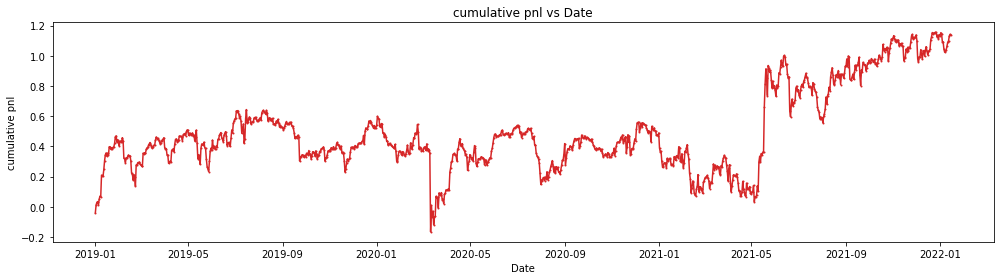

In [52]:
getPnlSummary[signalTbl]